# PME3481 - Controle e Aplicações

## Observador de Estados

### Configuração do Ambiente e Bibliotecas

Introdução das bibliotecas mais importantes.

In [18]:
# !pip install numpy --quiet
# !pip install matplotlib --quiet
# !pip install control --quiet

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import scipy
import control as ctrl
import sympy
import control.optimal as obc

In [2]:
def lqr(A, B, Q, R):
    """
    Parameters:
        A (numpy.ndarray): State matrix.
        B (numpy.ndarray): Input matrix.
        Q (numpy.ndarray): State cost matrix.
        R (numpy.ndarray): Input cost matrix.

    Returns:
        K (numpy.ndarray): Feedback gain matrix.
    """
    P = la.solve_continuous_are(A, B, Q, R)

    # Calculate the feedback gain matrix
    K = la.inv(R) @ B.T @ P
    return K

In [3]:
Xcm = 1.052
Xpe = 0.261
L = 3.304
Df = 0.127
Tlin = 230.57
Izz = 15.07
M = 23.545
g = 9.8055
dar = 1.091
Cd = 0.432
Vxlin = -10.0
Vvlin = 2.2

In [4]:
# X = [theta,xp,yp,thetap]
# Xp = [thetap,xpp,ypp,thetapp]
A = np.array([[0, 0, 0, 1],
              [(1/M)*((1/2)*dar*Cd*Vxlin**2*L*Df + (1/2)*dar*Cd*L*Df*Vvlin**2), (1/M)*(Vxlin *dar*Cd*((Df/2)**2*np.pi)), 0, 0],
              [(1/M)*(-M*g+(1/2)*Vxlin**2*dar*Cd*(np.pi*(Df/2)**2) - (1/2)*dar*Cd*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0],
              [(1/Izz)*((1/2)*Vxlin**2*dar*Xpe*Cd*(np.pi*(Df/2)**2)- (1/2)*dar*Cd*Xpe*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0]])

# u = [T,tau]

B = np.array([[0, 0, 0],
              [1/M, 0, 0],
              [0, -Tlin/M, - (1/2)*dar*Cd*L*Df*2*Vvlin],
              [0, -Tlin*Xcm/Izz, - (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin]]) 

# B = np.array([[0, 0, 0],
#               [1/M, 0, 0],
#               [0, -Tlin/M, 0],
#               [0, -Tlin*Xcm/Izz, 0]])

E = np.array([[0],
              [0],
              [ (- (1/2)*dar*Cd*L*Df*2*Vvlin)/(M*Izz)],
              [(- (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin)/(M*Izz)]])

C = np.array([[ 0, 1, 0, 0],
              [ 0, 0, 1, 0],])

D = np.array([[ 0, 0, 0],
              [ 0, 0, 0]])

cont = ctrl.StateSpace(A, B, C, D)

sys = ctrl.ss(A, B, C, D)
sys

<LinearIOSystem:sys[3]:['u[0]', 'u[1]', 'u[2]']->['y[0]', 'y[1]']>

In [5]:
Q = np.diag([1, 10, 1,1])          # don't turn too sharply
R = np.diag([0.1, 150, 1])  

Klqr = lqr(A,B, Q, R)

In [6]:
print(Klqr)

[[ 0.66360849  9.8383445   0.27654167 -0.0514717 ]
 [-0.76344129 -0.02950401  0.07829259 -0.37005085]
 [ 0.79204644 -0.26952991 -0.26998697  0.09010012]]


In [7]:
M = np.array([[0,1,0,0],[0,0,1,0]])
#Ar = A - np.dot(B,Klqr)
#Ar = A
Ar = -1*np.eye(4)

# seno/cosseno amortecido para posição/velocidade
w = 1
z = 0.5
#Ar = np.array([[-1,0,0,0], [0,-1,0,0],[-9,0,0,0],[(w**2+z**2),0,0,-2*z]])
# ω_s = 1.0        # [rad/s]
# ζ_s = 0         
#Ar = np.array([[0, 0, 0, 1], [0, -1, 0, 0], [0, 0, -1, 0],[-w ** 2, 0,0, -2 * z * w]])

Ar = -1 * np.eye(4)

F = (A - Ar)


A_cl_inv =(la.inv(A - B @ Klqr))


#A_cl_inv = np.round(A_cl_inv,6)
N = la.inv(M @ A_cl_inv @ B) @ M @ A_cl_inv

Gr = N @ F

print("N =",N)
print()

#Calculando aos poucos o Kex
Kex = np.dot(np.dot(np.dot(la.inv(np.dot(np.dot(M, A_cl_inv), B)), M), A_cl_inv), F)

Atot = np.block ([[A - np.dot(B,Klqr), np.dot(B,Klqr) - np.dot(B, Kex)], [np.zeros((4,4)),Ar]])


#Atot = np.block([[Aobs - Bobs @ Gr, Bobs @ (Klqr2 - Gr)], 
#                    [Ar - Aobs + Bobs @ Gr, Ar - Bobs @ (Klqr2 - G_r)]])

Btot = np.block([[B], [np.zeros_like(B)]])
Ctot  = np.eye(Atot.shape[0])
Dtot = np.zeros((Atot.shape[0], Btot.shape[1]))

print("Atot = ",Atot)
print()
print("Btot = ",Btot)
print()
print("Ctot = ",Ctot)
print()
print("Dtot = ",Dtot)
print()



ValueError: expected square matrix

(8, 8)


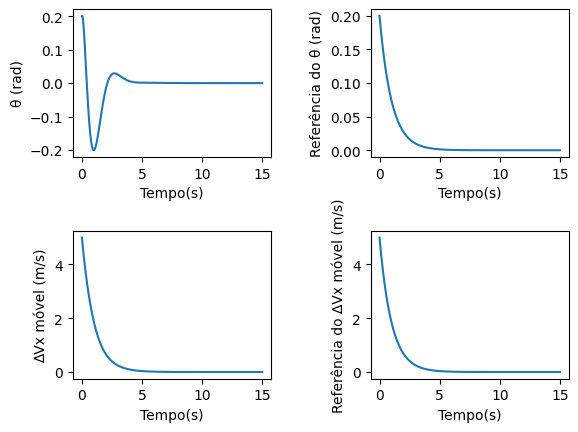

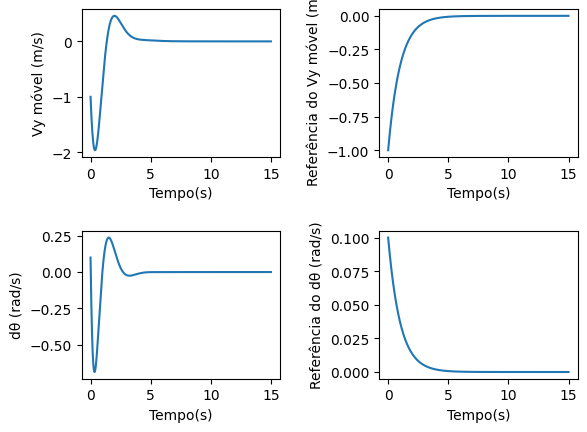

In [49]:
# Com o novo sistema, basta realizar as simulações
print(Atot.shape)
sysobs = ctrl.ss(Atot, np.zeros((8,2)), Ctot, Dtot)
# xT0 = np.array([[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0]])
# sysobs = ctrl.ss(Atot,xT0,Atot,xT0)

tempo = np.linspace(0, 15, 400000)

r = 100 #% do valor inicial
X0_x = [0.2, 5, -1, 0.1] #Valores iniciais dos estados 
X0  = [X0_x[0], X0_x[1], X0_x[2], X0_x[3],X0_x[0]*r/100, X0_x[1]*r/100, X0_x[2]*r/100, X0_x[3]*r/100]

t, u,yobs = ctrl.forced_response(sysobs, tempo, 0 ,X0 ,return_x = 'True')

f,((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.5,hspace=0.5)
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
ax3.set_xlabel('Tempo(s)')
ax4.set_xlabel('Tempo(s)')


ax1.plot(t, yobs[0])
ax1.set_ylabel('θ (rad)')

ax2.plot(t, yobs[4])
ax2.set_ylabel('Referência do θ (rad)')

ax3.plot(t, yobs[1])
ax3.set_ylabel('∆Vx móvel (m/s)')

ax4.plot(t, yobs[5])
ax4.set_ylabel('Referência do ∆Vx móvel (m/s)')

f,((ax5, ax6), (ax7,ax8)) = plt.subplots(2, 2)
plt.subplots_adjust( wspace=0.5,hspace=0.5)
ax5.set_xlabel('Tempo(s)')
ax6.set_xlabel('Tempo(s)')
ax7.set_xlabel('Tempo(s)')
ax8.set_xlabel('Tempo(s)')

ax5.plot(t, yobs[2])
ax5.set_ylabel('Vy móvel (m/s)')

ax6.plot(t, yobs[6])
ax6.set_ylabel('Referência do Vy móvel (m/s)')

ax7.plot(t, yobs[3])
ax7.set_ylabel('dθ (rad/s)')

ax8.plot(t, yobs[7])
ax8.set_ylabel('Referência do dθ (rad/s)')
plt.show(block=False)

In [50]:
uref = np.dot(Klqr,[yobs[4]-(yobs[0]),yobs[5]-(yobs[1]),yobs[6]-(yobs[2]),yobs[7]-(yobs[3]),]) - np.dot(Gr,yobs[4:8])

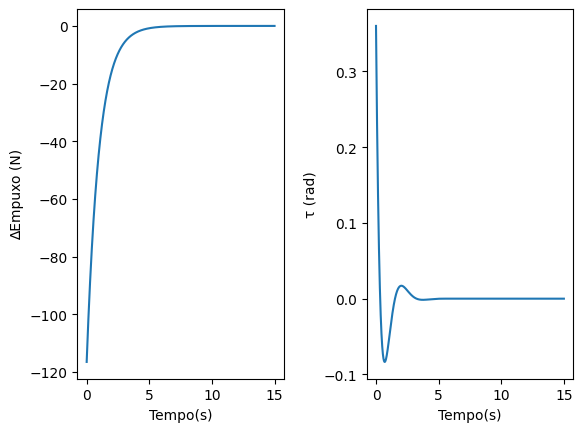

In [51]:
f,(ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust( wspace=0.4)
ax1.plot(t, uref[0])
ax1.set_ylabel('∆Empuxo (N)')

ax2.plot(t, uref[1])
ax2.set_ylabel('τ (rad)')
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
plt.show(block=False)

In [26]:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839, 0.0, 0.027),
    'dgreen': (0.341, 0.494, 0.094),
    'dblue': (0.063, 0.318, 0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [27]:
# A_r = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])

# seno/cosseno amortecido para posição/velocidade
ω_s = 1.0        # [rad/s]
ζ_s = 0         
#A_r = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [-ω_s ** 2, 0, -2 * ζ_s * ω_s, 0], [0, 0, 0, 0]])
A_r = -1*np.eye(4)

#A_r = A 

print(Klqr)

[[ 0.52063658  9.90007058  0.28397527 -0.08099821]
 [-0.78271178 -0.0231869   0.08131977 -0.37564641]]


In [28]:
# seleção de variável para seguir referência
M = np.array([[1, 0, 0, 0],[0, 1, 0, 0]])

# inversa da matriz de estados em MF
A_cl_inv = la.inv(A - B @ Klqr)

# ganho de pré-alimentação
N = la.inv(M @ A_cl_inv @ B) @ M @ A_cl_inv

G_r = N @ (A - A_r)
print(N)
print()
print(A - Ar)
print()
print(G_r)
coco = (-3 * 10 ** 15) * 1

[[-4.62267430e-01  2.35450000e+01 -1.54662676e+15  9.40988547e+14]
 [-4.84827490e-01 -1.26336547e-17 -4.42895378e+14  2.69463512e+14]]

[[ 0.          0.          0.          0.        ]
 [ 0.41997512  0.99746425  0.          0.        ]
 [-9.79282123  0.          1.          0.        ]
 [ 1.00517015  0.          0.          1.        ]]

[[ 1.51507044e+16  2.34852957e+01 -1.54662676e+15  9.40988547e+14]
 [ 4.33858842e+15 -1.26016188e-17 -4.42895378e+14  2.69463512e+14]]


In [29]:
# matrizes do sistema estendido em malha fechada
A_ex_cl = np.block([[A - B @ G_r, B @ (Klqr - G_r)], 
                    [A_r - A + B @ G_r, A_r - B @ (Klqr - G_r)]])
E_ex_cl = np.block([np.zeros((8, 1))])
K_ex = np.block([[-G_r, Klqr - G_r]])

# forma de espaço de estados
furuta_ex_cl_SS = ctrl.ss(A_ex_cl, E_ex_cl, K_ex, 0)
furuta_ex_cl_SS

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-6.43478633e+14, -1.00000000e+00,  6.56881188e+13,
        -3.99655361e+13, -6.43478633e+14, -5.76989810e-01,
         6.56881188e+13, -3.99655361e+13],
       [ 4.24866567e+16, -1.23404343e-16, -4.33715809e+15,
         2.63878539e+15,  4.24866567e+16,  2.27063193e-01,
        -4.33715809e+15,  2.63878539e+15],
       [ 6.98318810e+16, -2.02829736e-16, -7.12863593e+15,
         4.33715809e+15,  6.98318810e+16,  3.73205404e-01,
        -7.12863593e+15,  4.33715809e+15],
       [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00],
       [ 6.43478633e+14,  1.11022302e-16, -6.56881188e+13,
         3.99655361e+13,  6.43478633e+14, -4.23010190e-01,
        -6.56881188e+13,  3.99655361e+13],
       [-4.24866567e+16

[[0.2 nan nan ... nan nan nan]
 [5.  nan nan ... nan nan nan]
 [0.  nan nan ... nan nan nan]
 ...
 [4.  nan nan ... nan nan nan]
 [0.  nan nan ... nan nan nan]
 [0.  nan nan ... nan nan nan]]


c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_matfuncs.py:380: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_matfuncs.py:380: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


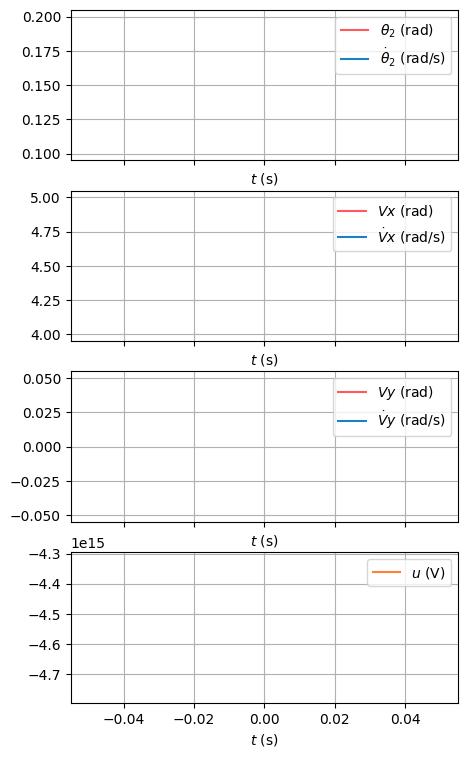

In [30]:
ts = np.linspace(0, 25, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [0.2, 5, 0.0, 0.0, 
      0.1, 4, 0.0, 0.0]
# x0 = [0.0, 0.3, 0.0, 0.0,
#       0.0, 0.0, 1.0, 0.0]
t, u, x = ctrl.forced_response(furuta_ex_cl_SS, U=0, T=ts, X0=x0, return_x=True)

fig, (state_pend, state_base, error_base, control_input) = plt.subplots(
    4, 1, figsize=(5, 9), sharex=True)

print(x)    

state_pend.plot(t, x[0, :], color=cp['red'], label=r'$\theta_2$ (rad)')
state_pend.plot(t, x[4, :], color=cp['blue'], label=r'$\dot \theta_2$ (rad/s)')
state_pend.set_xlabel(r'$t$ (s)')
state_pend.legend()
state_pend.grid()

state_base.plot(t, x[1, :], color=cp['red'], label=r'$Vx$ (rad)')
state_base.plot(t, x[5, :], color=cp['blue'], label=r'$\dot Vx$ (rad/s)')
state_base.set_xlabel(r'$t$ (s)')
state_base.legend()
state_base.grid()

error_base.plot(t, x[2, :], color=cp['red'], label=r'$Vy$ (rad)')
error_base.plot(t, x[6, :], color=cp['blue'], label=r'$\dot Vy$ (rad/s)')
error_base.set_xlabel(r'$t$ (s)')
error_base.legend()
error_base.grid()

control_input.plot(t, u[0, :], color=cp['orange'], label=r'$u$ (V)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

Tentando com o Sympy


In [31]:
a1 =  0
a2 = 0
a3 = 0
a4 = sympy.Symbol('a4')
a5 = sympy.Symbol('a5')
a6 = sympy.Symbol('a6') 
a7 = 0
a8 = 0
a9 = sympy.Symbol('a9')
a10= 0
a11= 0
a12= 0
a13= sympy.Symbol('a13')
a14= 0
a15= 0
a16= 0
As = sympy.Matrix(4,4,[a1, a2, a3, a4, a5, a6, a7,a8, a9, a10, a11, a12,a13, a14, a15, a16])

b1 = 0
b2 = 0
b3 = sympy.Symbol('b3')
b4 = 0
b5 = 0
b6 = sympy.Symbol('b6') 
b7 = 0
b8 = sympy.Symbol('b8')
Bs = sympy.Matrix(4,2,[b1, b2, b3, b4, b5, b6, b7,b8])

k1 = sympy.Symbol('k1')
k2 = sympy.Symbol('k2')
k3 = sympy.Symbol('k3')
k4 = sympy.Symbol('k4')
k5 = sympy.Symbol('k5')
k6 = sympy.Symbol('k6') 
k7 = sympy.Symbol('k7')
k8 = sympy.Symbol('k8')
Ks = sympy.Matrix(2,4,[k1, k2, k3, k4, k5, k6, k7,k8])
Ks


Matrix([
[k1, k2, k3, k4],
[k5, k6, k7, k8]])

In [32]:
Ms = sympy.Matrix(([0,0,1,0],[0,1,0,0]))

Ars = -1 * sympy.eye(4)
Ars

Matrix([
[-1,  0,  0,  0],
[ 0, -1,  0,  0],
[ 0,  0, -1,  0],
[ 0,  0,  0, -1]])

In [52]:
Fs = (As - Ars)


A_cl_inv_s = As - Bs * Ks

A_cl_inv_s = A_cl_inv_s.inv()

# =(la.inv(A - B @ Klqr))
Ns = Ms * A_cl_inv_s * Bs
print('oi')
#Ns = Ns.inv()
#print('oi')
#Ns = Ns * Ms * A_cl_inv_s

Ns
# N = la.inv(M @ A_cl_inv @ B) @ M @ A_cl_inv

# Gr = N @ F

oi


Matrix([
[-b3*k6/(a6*k7 - b3*k2*k7 + b3*k3*k6), b6*(a13*a6 - a13*b3*k2 + a5*b8*k6 - a6*b8*k5 - b3*b8*k1*k6 + b3*b8*k2*k5)/(-a13*a6*b6*k7 + a13*b3*b6*k2*k7 - a13*b3*b6*k3*k6 + a6*a9*b8*k7 - a9*b3*b8*k2*k7 + a9*b3*b8*k3*k6) + b8*(-a5*b6*k6 - a6*a9 + a6*b6*k5 + a9*b3*k2 + b3*b6*k1*k6 - b3*b6*k2*k5)/(-a13*a6*b6*k7 + a13*b3*b6*k2*k7 - a13*b3*b6*k3*k6 + a6*a9*b8*k7 - a9*b3*b8*k2*k7 + a9*b3*b8*k3*k6)],
[ b3*k7/(a6*k7 - b3*k2*k7 + b3*k3*k6),                                         b6*(a13*b3*k3 - a5*b8*k7 + b3*b8*k1*k7 - b3*b8*k3*k5)/(-a13*a6*b6*k7 + a13*b3*b6*k2*k7 - a13*b3*b6*k3*k6 + a6*a9*b8*k7 - a9*b3*b8*k2*k7 + a9*b3*b8*k3*k6) + b8*(a5*b6*k7 - a9*b3*k3 - b3*b6*k1*k7 + b3*b6*k3*k5)/(-a13*a6*b6*k7 + a13*b3*b6*k2*k7 - a13*b3*b6*k3*k6 + a6*a9*b8*k7 - a9*b3*b8*k2*k7 + a9*b3*b8*k3*k6)]])

In [74]:

a1= sympy.Symbol('a1')
a3= sympy.Symbol('a3')
a4= sympy.Symbol('a4')
a5= sympy.Symbol('a5')
a6= sympy.Symbol('a6')
a7= sympy.Symbol('a7')
a8= sympy.Symbol('a8')
a9= sympy.Symbol('a9')
a10= sympy.Symbol('a10')
a11= sympy.Symbol('a11')
a12= sympy.Symbol('a12')
a13= sympy.Symbol('a13')
a14= sympy.Symbol('a14')
a15= sympy.Symbol('a15')
a16= sympy.Symbol('a16')
a17= sympy.Symbol('a17')
a18= sympy.Symbol('a18')
a19= sympy.Symbol('a19')
a20= sympy.Symbol('a20')
a21= sympy.Symbol('a21')
a22= sympy.Symbol('a2')
a23= sympy.Symbol('a23')
a24= sympy.Symbol('a24')
a25= sympy.Symbol('a25')
a26= sympy.Symbol('a26')

A_e1 = sympy.Matrix((
    [a1,a2,0,0,0,0,a3],
    [a4,a5,0,0,a6,0,0],
    [0,0,a7,a8,0,a9,0],
    [a10,a11,a12,a13,a14,0,0],
    [0,a15,0,0,a16,a17,0],
    [0,0,a18,0,a19,a20,0],
    [a21,a22,a23,a24,a25,0,a26]))


Br =sympy.Matrix((
[0,0],
[b3,0],
[0,0],
[0,b6],
[b8,0],
[0,0],
[0,0]
))

k1 = sympy.Symbol('k1')
k2 = sympy.Symbol('k2')
k3 = sympy.Symbol('k3')
k4 = sympy.Symbol('k4')
k5 = sympy.Symbol('k5')
k6 = sympy.Symbol('k6') 
k7 = sympy.Symbol('k7')
k8 = sympy.Symbol('k8')
k9 = sympy.Symbol('k9')
k10 = sympy.Symbol('k10')
k11 = sympy.Symbol('k11')
k12 = sympy.Symbol('k12')
k13 = sympy.Symbol('k13')
k14 = sympy.Symbol('k14') 
Kr = sympy.Matrix(2,7,[k1, k2, k3, k4, k5, k6, k7,k8,k9,k10,k11,k12,k13,k14])
Kr

Matrix([
[k1, k2,  k3,  k4,  k5,  k6,  k7],
[k8, k9, k10, k11, k12, k13, k14]])

In [75]:
Mr = sympy.Matrix((
    [0,1,0,0,0,0,0],
    [0,0,0,0,1,0,0]))

ar1= sympy.Symbol('ar1')
ar2= sympy.Symbol('ar2')
ar3= sympy.Symbol('ar3')
ar4= sympy.Symbol('ar4')
ar5= sympy.Symbol('ar5')
ar6= sympy.Symbol('ar6')
ar7= sympy.Symbol('ar7')
ar8= sympy.Symbol('ar8')
ar9= sympy.Symbol('ar9')
ar10= sympy.Symbol('ar10')
ar11= sympy.Symbol('ar11')
ar12= sympy.Symbol('ar12')
A_w1 = sympy.zeros((5))
A_r1 = sympy.Matrix((
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,ar1,0,0,ar2,ar3,0],
    [0,0,ar4,0,ar5,ar6,0],
    [ar7,ar8,ar9,ar10,ar11,0,ar12]))

zeros1 = sympy.zeros(5,7)
zeros2 = sympy.zeros(7,5)
manga = A_w1.row_join(zeros1)
banana = zeros2.row_join(A_r1)
A01 = manga.col_join(banana)
A01

Matrix([
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0,   0,   0,    0,    0,   0,    0],
[0, 0, 0, 0, 0,   0, ar1,   0,    0,  ar2, ar3,    0],
[0, 0, 0, 0, 0,   0,   0, ar4,    0,  ar5, ar6,    0],
[0, 0, 0, 0, 0, ar7, ar8, ar9, ar10, ar11,   0, ar12]])

In [81]:



A_cl_inv_r = A_e1 - Br * Kr

A_cl_inv_r = A_cl_inv_r.inv()

# =(la.inv(A - B @ Klqr))
# Nr = Mr * A_cl_inv_r * Br
# print('oi')
#Ns = Ns.inv()
#print('oi')
#Ns = Ns * Ms * A_cl_inv_s

A_cl_inv_r
# N = la.inv(M @ A_cl_inv @ B) @ M @ A_cl_inv

# Gr = N @ F

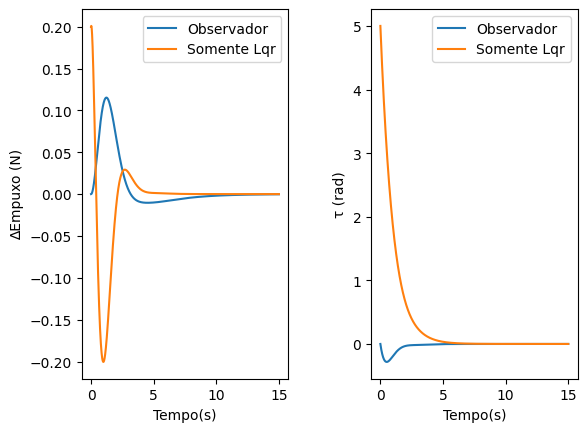

In [60]:
uobs = np.dot(-Klqr,[yobs[0]-yobs[4],yobs[1]-yobs[5],yobs[2]-yobs[6],yobs[3]-yobs[7]])
f,(ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4,hspace=0.5)
ax1.plot(t, uobs[0])
ax1.plot(t, u[0])
ax1.legend(['Observador', 'Somente Lqr'])
ax1.set_ylabel('∆Empuxo (N)')

ax2.plot(t, uobs[1])
ax2.plot(t, u[1])
ax2.legend(['Observador', 'Somente Lqr'])
ax2.set_ylabel('τ (rad)')

ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
plt.show(block=False)